# 2 Clasificación multi-clase y clasificación multi-etiqueta

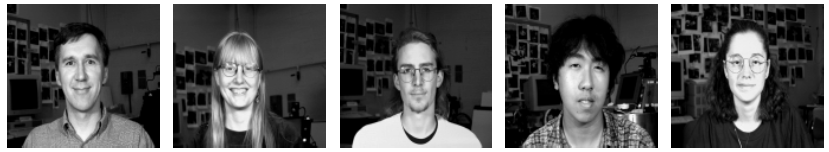

Esta actividad nos brinda la oportunidad de aplicar la técnica de redes neuronales al problema de reconocimiento de rostros. La actividad se divide en dos etapas.

- La `primer etapa` consiste en construir un modelo basado en redes neuronales para el reconocimiento de rostros en imágenes. Para este caso, se tienen tres clases: an2i, tammo y saavik. La actividad es guiada y utilizará el dataset: `faces.hdf5`.

- ***La `segunda etapa` consiste en construir un modelo basado en redes neuronales para identificar la postura del rostro que se encuentra en la imagen (de frente, arriba, izquierda, derecha). Esta actividad es idividual y utilizará el conjunto de imágenes que se encuentran en el archivo: `faces.zip`.***

Las imágenes que utilizaremos, son rostros de estudiantes en la Universidad de Carnegie Mellon (curso de Machine Learning, profesor Tom Mitchel). Las imágenes son públicas y pueden ser descargadas de diversos repositorios en la web. Nosotros utilizaremos un subconjunto del dataset original, preparado para nuestra actividad.


In [61]:
import zipfile

In [62]:
from matplotlib import pyplot as plt
import numpy as np

# Etapa 2 - Ejemplo parcial de clasificación multi-etiqueta

Hemos llegado a la `segunda etapa`, que  consiste en construir un modelo basado en redes neuronales para identificar la postura del rostro que se encuentra en la imagen (de frente, arriba, izquierda, derecha). Adicionalmente, su modelo deberá indicar si la persona de la imagen tiene lentes o no.

- Esta actividad es individual.

- Para construir su modelo utilizará el conjunto de imágenes que se encuentran en el archivo: `faces.zip`.

- Al finalizar su trabajo, entregue su implementación mediante CANVAS.


In [63]:
# Iniciemos por descomprimir el archivo que contiene las imágenes que utilizaremos para construir, entrenar y validar
# la red neuronal que nos permita realizar la tarea descrita

with zipfile.ZipFile("./dataset/faces.zip", "r") as zip_ref:
    zip_ref.extractall("./dataset")

# Construcción del conjunto de datos con etiquetas (anotaciones)

Con el objetivo de construir un conjunto de datos que podamos utilizar para entrenar y validar la red neuronal, realizaremos lo siguiente:

a) Analizar las imágenes que tenemos disponibles para la construcción del conjunto de datos.

b) Dada una ruta raíz en la que se encuentran almacenadas todas las imágenes, vamos crear una lista llamada ***images*** que contenga el path y nombre de cada imagen que se encuentre en la ruta ráiz o en subdirectorios.


In [64]:
# Obtener listados de imágenes disponibles para la construcción del conjunto de dato
import os

data_path = './dataset/faces'

classes = []
images = []

for root, dirs, files in os.walk(data_path):
   for name in files:
      if(name.endswith('.DS_Store')):
         continue
      images.append(os.path.normpath(os.path.join(root, name)).replace("\\", "/"))
   for name in dirs:
      classes.append(name)

print("Clases: ", classes)
print("No. de imágenes: ", len(images))

Clases:  ['boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'mitchell', 'phoebe', 'tammo']
No. de imágenes:  752


c) Dada la lista ***images*** vamos a crear la siguientes funciones:


*   **load_image_pgm(file_path, shape = None, flatten = True) ** - Recibe la ruta y nombre de un archivo de imagen (***pgm***), las dimensiones 2D que queremos para la imagen. Adicionalmente, podemos indicar mediante ***flatten*** si queremos que la imagen se represente mediante un vector o una matriz. La función retorna la imagen cargada a memoria como una matriz(flatten = False) o vector (flatten = True).  


In [65]:
# Implementemos una función que dada la ruta y nombre de un archivo (pgm) cargue en memoria la imagen en escala de grises
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def load_image_pgm(file_path, shape=None, flatten=False):
  img = cv.imread(file_path, cv.IMREAD_GRAYSCALE)
  if shape is not None:
    img = cv.resize(img, (shape[0], shape[1]), interpolation=cv.INTER_CUBIC)  #Redimensionar imagen a: (h, w)
  if flatten is True:
    img = np.reshape(img, (img.shape[0]* img.shape[1]))
  return img

dataset/faces/boland/boland_left_angry_open.pgm
(60, 60)


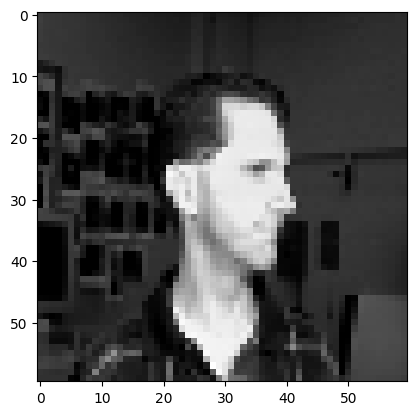

In [66]:
# Probemos nuestra función y visualicemos la imagen que se cargo en memoria
print(images[0])
img = load_image_pgm(images[0], shape=(60, 60), flatten=False)
print(img.shape)

# Visualicemos la imagen
plt.imshow(img, cmap='gray')


*   **get_labels(file_path, one_hot_vector=True)** - Recibe la ruta y nombre de un archivo de imagen (***pgm***). Opcionalmente podemos indicar si queremos que la función retorne la etiqueta de la imagen utilizando una representación escalar ***(One_hot_vector = False)*** o vectorial ***(One_hot_vector = True)***. En el siguiente ejemplo, la función retorna la clase a la que pertenece cada imagen y adicionalmente las etiquetas sobre postura, estado emocional y si la persona tienes lentes o no.


In [67]:
# Implementemos una función que dada la ruta y el nombre del archivo de una imágen genere
# su respectiva etiqueta

# Definamos algunos diccionarios para representar las etiquetas de forma numérica
name2class = {'mitchell':0, 'tammo':1, 'phoebe':2, 'ch4f':3, 'boland':4, 'bpm':5, 'cheyer':6, 'choon':7}
head_orientation2label = {'left':0, 'right':1,'straight':2,'up':3}
feeling2label = {'angry':0,'happy':1,'neutral':2,'sad':3}
glasses2label = {'open':0, 'sunglasses':1}

def get_labels(file_path, one_hot_vector=True):

  #Quitaremos la extensión para evitar problemas al momento de extraer las etiquetas del nombre del archivo
  file_path = file_path.split('.')[0]

  filename = file_path.split('/')[-1]
  name_head_feeling_glasses = filename.split('_')
  #print(name_head_feeling_glasses)

  name = name_head_feeling_glasses[0]
  cls = name2class[name]                # Clase a la que pertenece la imagen

  head = name_head_feeling_glasses[1]
  head = head_orientation2label[head]

  feeling = name_head_feeling_glasses[2]
  feeling = feeling2label[feeling]

  glasses = name_head_feeling_glasses[3]
  glasses = glasses2label[glasses]

  labels = np.array([head, feeling, glasses])  # Etiquetas de la imagen
  #print(labels)

  if one_hot_vector is True:
    cls = np.eye(8)[cls]
    head = np.eye(4)[head]
    feeling = np.eye(4)[feeling]
    glasses = np.eye(2)[glasses]
    labels = np.concatenate([head, feeling, glasses])
  return cls, labels

In [68]:
# Probemos la función

get_labels(images[0], one_hot_vector=False)

(4, array([0, 0, 0]))

In [69]:
cls, labels = get_labels(images[0], one_hot_vector=True)
print("Clase: ", cls)
print("Etiquetas: ", labels)

Clase:  [0. 0. 0. 0. 1. 0. 0. 0.]
Etiquetas:  [1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


Es momento de utilizar las funciones previamente creadas para cargar imágenes a memoria y generar las etiquetas con el fin de crear nuestro conjunto de datos de entrenamiento con imágenes y etiquetas.

In [70]:
# Debido a que tenemos pocas imágenes probemos cargar todo a memoria de forma simultanea
# sin embargo, al trabajar con grandes cantidades de datos se requieren implementar generadores
# de datos que carguen poco a poco los datos en memoria durante el entrenamiento y validación
X = []
Y = []
for i in range(len(images)):
  X.append(load_image_pgm(images[i], shape=(60, 60), flatten=True))
  Y.append(get_labels(images[i])[1])

print(X)
print(Y)

[array([60, 55, 55, ..., 65, 64, 60], dtype=uint8), array([36, 34, 33, ..., 39, 38, 36], dtype=uint8), array([35, 35, 34, ..., 40, 38, 38], dtype=uint8), array([55, 53, 52, ..., 53, 52, 50], dtype=uint8), array([34, 33, 33, ..., 33, 32, 31], dtype=uint8), array([34, 34, 32, ..., 34, 32, 31], dtype=uint8), array([60, 57, 55, ..., 64, 62, 59], dtype=uint8), array([36, 34, 33, ..., 38, 37, 35], dtype=uint8), array([35, 35, 33, ..., 38, 37, 36], dtype=uint8), array([54, 53, 52, ..., 53, 50, 50], dtype=uint8), array([34, 33, 32, ..., 33, 31, 31], dtype=uint8), array([33, 33, 32, ..., 34, 32, 31], dtype=uint8), array([57, 55, 53, ..., 56, 52, 49], dtype=uint8), array([34, 33, 33, ..., 34, 32, 30], dtype=uint8), array([33, 33, 32, ..., 35, 32, 31], dtype=uint8), array([57, 55, 54, ..., 52, 51, 48], dtype=uint8), array([35, 35, 34, ..., 33, 32, 30], dtype=uint8), array([35, 35, 33, ..., 34, 32, 31], dtype=uint8), array([59, 56, 54, ..., 64, 63, 59], dtype=uint8), array([36, 34, 33, ..., 39, 38

In [71]:
X = tf.constant(X, dtype=tf.float32)
Y = tf.constant(Y, dtype=tf.float32)
print(X.shape, Y.shape)

(752, 3600) (752, 10)


## Próximos pasos

- Diseño de la red neuronal tipo perceptrón multicapa
  - Capas de entra, capas ocultas y capa de salida.
  - Función de costo, métricas, algoritmo de optimización

- Entrenamiento de la red neuronal

- Evaluación de desempeño (visualización del loss y métricas con datos de entrenamiento y validación). Recordemos que nuestro objetivo en desempeño se espera un mínimo del 95% (accuracy).

- Evaluación del desempeño de la red neuronal utilizando como métrica F1-score (su implementación se encuentra en el ejemplo sobre el uso de modelos preentrenados).

- Implementación de funciones requeridas para interpretar las predicciones realizadas por la red neruonal (valores numéricos) a una representación simbólica.

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

neural_network = tf.keras.Sequential([Input(shape=(3600,)), Dense(512, activation='relu'),
                                      Dense(256, activation='relu'), Dense(128, activation='relu'), Dense(64, activation='relu'),
                                      Dense(32, activation='relu'), Dense(10, activation='sigmoid')])



In [91]:
# Dividir los datos en conjuntos de entrenamiento y validación
indices = np.random.permutation(len(X))

# Definir el tamaño del conjunto de validación
val_size = int(len(X) * 0.2)

# Dividir los índices en conjuntos de entrenamiento y validación
val_indices = indices[:val_size]
train_indices = indices[val_size:]

# Convertir los índices a tensores de TensorFlow
val_indices = tf.convert_to_tensor(val_indices, dtype=tf.int32)
train_indices = tf.convert_to_tensor(train_indices, dtype=tf.int32)

# Seleccionar los datos correspondientes a los índices
X_train, X_val = tf.gather(X, train_indices), tf.gather(X, val_indices)
y_train, y_val = tf.gather(Y, train_indices), tf.gather(Y, val_indices)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

print(X_train.shape, y_train.shape)


(602, 3600) (602, 10)
(150, 3600) (150, 10)
(602, 3600) (602, 10)


In [101]:

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
# Compilar la red neuronal
neural_network.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Entrenar la red neuronal
history = neural_network.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val))

Epoch 1/300


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5510 - loss: 0.1603 - val_accuracy: 0.3800 - val_loss: 0.1811
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5604 - loss: 0.0466 - val_accuracy: 0.5133 - val_loss: 0.2078
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4820 - loss: 0.0219 - val_accuracy: 0.5533 - val_loss: 0.2061
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5367 - loss: 0.0167 - val_accuracy: 0.5200 - val_loss: 0.2059
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5658 - loss: 0.0108 - val_accuracy: 0.5067 - val_loss: 0.2287
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5539 - loss: 0.0141 - val_accuracy: 0.5267 - val_loss: 0.2048
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5506 - loss: 0.0052 - val_accuracy: 0.6000 - val_loss: 0.2572
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5458 - loss: 0.0174 - val_accuracy: 0.4467 - val_loss: 0.2

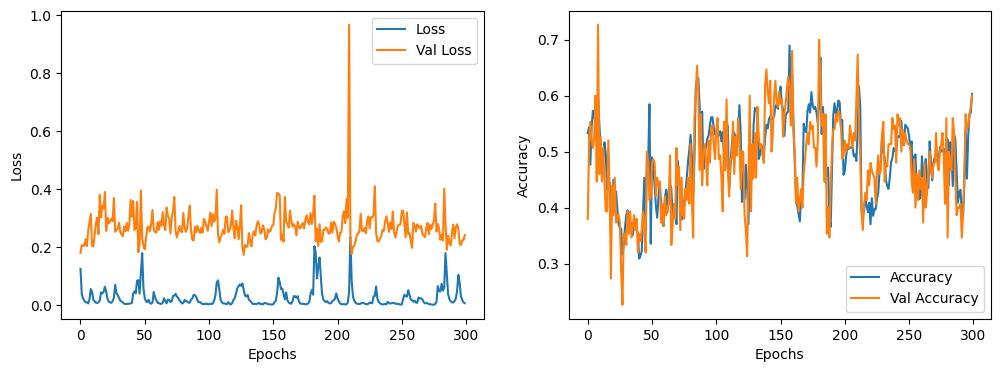

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
F1-score: 0.8599994798615604
Predicciones: [0 0 0 2 3 3 1 1 1 0 9 0 8 8 0 2 1 1 3 9 0 0 2 1 1 3 1 9 0 3 8 9 9 9 9 1 1
 2 0 9 9 9 9 2 2 1 3 9 3 2 2 1 2 2 1 1 1 2 9 3 0 9 3 2 3 9 2 8 3 1 2 9 9 2
 0 2 1 2 0 0 8 3 1 0 2 9 0 9 0 0 3 0 3 0 3 1 8 9 3 2 2 3 2 9 1 3 1 0 1 0 2
 3 2 9 0 2 8 0 2 3 1 2 1 2 8 3 2 9 1 2 1 0 3 3 0 3 2 0 2 1 0 2 9 9 2 9 2 1
 2 0]
Etiquetas verdaderas: [0 0 0 2 3 3 1 1 1 0 1 0 3 3 0 2 1 1 3 0 0 0 2 1 1 3 1 3 0 1 1 3 3 3 3 1 1
 2 0 2 0 1 3 2 2 1 3 3 3 2 2 1 2 2 1 1 1 2 1 3 0 3 3 2 3 1 2 2 3 1 2 2 3 2
 0 2 1 2 0 0 3 3 1 0 2 0 0 1 0 0 3 0 3 0 3 1 1 0 3 2 2 3 2 0 1 3 1 0 1 0 2
 3 2 1 0 2 1 0 2 3 1 2 1 2 1 3 2 3 1 2 1 0 3 3 0 3 2 0 2 1 0 2 0 3 2 1 2 1
 2 0]
Distribución de las clases en las etiquetas verdaderas: {0: 35, 1: 40, 2: 38, 3: 37}
Distribución de las clases en las predicciones: {0: 29, 1: 28, 2: 35, 3: 24, 8: 8, 9: 26}
Distribución de las clases en los datos de entrenamiento: {0: 153, 1: 146, 2: 152, 3: 151}
5/5 ━━━━━━━━━━━━━━━

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Visualización del loss y métricas
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluación del desempeño utilizando F1-score
y_pred = neural_network.predict(X_val)

# Convertir las predicciones a etiquetas binarias
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calcular el F1-score
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
print(f"F1-score: {f1}")

print("Predicciones:", y_pred_classes)
print("Etiquetas verdaderas:", y_val_classes)

# Verificar la distribución de las clases en las etiquetas verdaderas
unique, counts = np.unique(y_val_classes, return_counts=True)
print("Distribución de las clases en las etiquetas verdaderas:", dict(zip(unique, counts)))

# Verificar la distribución de las predicciones
unique_pred, counts_pred = np.unique(y_pred_classes, return_counts=True)
print("Distribución de las clases en las predicciones:", dict(zip(unique_pred, counts_pred)))

# Verificar la distribución de las clases en los datos de entrenamiento
unique_train, counts_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print("Distribución de las clases en los datos de entrenamiento:", dict(zip(unique_train, counts_train)))

# Evaluación del desempeño utilizando F1-score después de entrenar
y_pred = neural_network.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
print(f"F1-score después de entrenar: {f1}")